In [1]:
import pandas as pd
from statsmodels.stats.contingency_tables import cochrans_q, mcnemar
import statsmodels.stats
import scipy.stats
import numpy as np
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import matplotlib

In [2]:
THRESHOLD = 0.05 #alpha significance level
PREDICTIONS_DIR = 'predictions'

tasks = {
    'binary': [0, 1], 
    'strat-binary': [0, 1],
    '4type': [0, 1, 2, 3],
    '5type': [0, 1, 2, 3, 4],
}
representations = ['bow', 'freq', 'tfidf']
models = ['decision-tree', 'svm', 'naive-bayes', 'xgboost']
methods = ['RandomUnder', 'SMOTETomek', 'RandomOver', 'ADASYN', 'none', 'aug']

In [3]:
#find the mode of a numpy array
def mode(array):
    freq = np.bincount(array)
    return np.argmax(freq)

In [4]:
def shorten_name(name):
    shortenings = {
    'decision-tree': 'dt',
    'naive-bayes-multinomial': 'nbm',
    'naive-bayes': 'nb',
    'xgboost': 'xgb',
    '-classification': '',
    '-type_of_antisemitism': '',}
    for long_version in shortenings:
        name = name.replace(long_version, shortenings[long_version])
    return name

#visualize the results of a post-hoc dunn analysis on a cochran's q test using matplotlib in a matrix
def visualize_dunn(dunn_values, names):
    names = [shorten_name(name) for name in names]
    
    plt.matshow(dunn_values)
    ax = plt.gca()
    ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
    ax.set_xticklabels(labels=names,rotation=90)
    ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
    ax.set_yticklabels(labels=names)
    
    #pulled these next two lines from stack overflow, just to display the values
    for (i, j), z in np.ndenumerate(dunn_values):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
        
    plt.pause(0.1)

In [5]:
#find the raw accuracy scores of all of the columns
def find_accuracy(df):
    accuracies = [1,]
    for column in [column for column in df.columns.values if column != 'Actual']:
        df[column] = df.apply(lambda x: int(x[column] == x['Actual']), axis=1)
        accuracies.append(df[column].mean())
    return accuracies

In [6]:
#combine columns in a dataframe whose names contain certain substrings
def combine_columns(df, substrings):
    '''
    df: the input dataframe that has many column names that contain certain common substrings
    substrings: the list of substrings used for combination
    
    returns: `output_df`, a DataFrame with `substrings` as its columns. Each row is the mode
    of the value for that row of all of the columns in `df` that contained that substring.
    '''
    output_df = pd.DataFrame()
    
    for column_substring in substrings:
        temp_df = pd.DataFrame()
        to_be_combined = [column for column in df.columns.values if column_substring in column]
        
        for column in to_be_combined:
            temp_df[column] = df[column]
            
        array = np.array(temp_df).astype(int)
        array = [mode(row) for row in array]
            
        output_df[column_substring] = array
    
    return output_df

In [7]:
#find which models performed best using basic accuracy score
def evaluate_models(df, substrings):
    output_df = pd.DataFrame()
    temp_df = combine_columns(df, substrings)
    for column in substrings:
        temp_df[column] = temp_df[column] == df['Actual']
        output_df[column] = [sum(temp_df[column])/len(temp_df),]
    output_df.index = ['Score']
    if 'index' in output_df.columns.values: del output_df['index']
    return output_df

#test model significance difference w/ Friedman Chi^2 while combining certain columns
def test_model_difference(df, substrings):
    df = combine_columns(df, substrings)
    columns = [df[substring] for substring in substrings]
    cochran_result = cochrans_q(columns)
    return cochran_result

def post_hoc_tests(df, substrings):
    df = combine_columns(df, substrings)
    columns = [df[substring] for substring in substrings]
    p_values = sp.posthoc_dunn(columns)
    return p_values

In [8]:
#get a list of binary dfs of whether or not they fit with a particular classification
def get_dfs(df, classifications):
    dfs = []
    for classification in classifications:
        temp_df = df[df['Actual'] == classification]
        temp_df = temp_df.reset_index()
        dfs.append(temp_df)
    return dfs

#find specific rankings for each model
def overall_evaluation(task, classifications, method):
    df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-{method}.csv')
    score_df = pd.DataFrame()
    dfs = get_dfs(df, classifications)
        
    for (i, temp_df) in enumerate(dfs):
        temp_df = evaluate_models(temp_df, temp_df.columns.values).transpose()
        temp_df = temp_df.sort_values('Score', ascending=False)
            
        score_df[f'Score {i}'] = temp_df['Score']
    
    score_df['Mean score'] = score_df.mean(axis=1)
    score_df['Accuracy'] = find_accuracy(df)
    score_df = score_df.sort_values('Mean score', ascending = False)
    cochran_result = cochrans_q(df)
    post_hoc_p = pd.DataFrame()
    if cochran_result.pvalue <= THRESHOLD:
        post_hoc_p = post_hoc_tests(df, df.columns.values)
    
    print(f'Task: {task}.')
    print(f"Cochran's Q test p-value: {cochran_result.pvalue}")
    if cochran_result.pvalue <= THRESHOLD:
        print('Post-hoc Dunn test array:')
        visualize_dunn(post_hoc_p, df.columns.values)
    
    score_df.index = [shorten_name(name) for name in score_df.index]
    print(score_df)
    print(f'\nMean: {score_df["Mean score"].mean()}')
    print('\n\n')
    return score_df

In [9]:
def evaluate_rep_model(grouping, dfs):
    final_df = pd.DataFrame()
    
    for i, df in enumerate(dfs):
        temp_df = evaluate_models(df, grouping).transpose()
        temp_df = temp_df.sort_values('Score', ascending=False)
        
        temp_df.columns = ['Score']
        final_df[f'Score {i}'] = temp_df['Score']
        
    return final_df

#evaluate algorithms and representations, find significance level
def algorithm_and_rep_eval(task, classifications, method):
    df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-{method}.csv')
    dfs = []
    for classification in classifications:
        temp_df = df[df['Actual'] == classification]
        temp_df = temp_df.reset_index()
        dfs.append(temp_df)
    for grouping in [representations, models]:
        score_df = evaluate_rep_model(grouping, dfs)
        score_df['Mean score'] = score_df.mean(axis=1)
        score_df = score_df.sort_values('Mean score', ascending = False)
        
        combined_df = combine_columns(df, grouping)
        cochran_result = cochrans_q(combined_df)
        if cochran_result.pvalue <= THRESHOLD:
            post_hoc_p = post_hoc_tests(combined_df, grouping)
        
        print(f'Task: {task}. Grouping: {grouping}.')
        print(f"Cochran's Q test p-value: {cochran_result.pvalue}")
        if cochran_result.pvalue <= THRESHOLD:
            print('Post-hoc Dunn test array:')
            visualize_dunn(post_hoc_p, grouping)
        
        score_df.index = [shorten_name(name) for name in score_df.index]
        print(f"Scores: \n{score_df}")
        print(f'\nMean: {score_df["Mean score"].mean()}')
        print('\n\n')

In [10]:
#evaluate the overall resampling methods, perform friedman test and post-hoc nemenyi
def evaluate_resampling(overall_df, indeces):
    columns = [overall_df[column] for column in overall_df.columns.values]
    statistic, pvalue = scipy.stats.friedmanchisquare(*columns)
    overall_df.loc[len(overall_df)] = overall_df.apply(lambda x: np.mean(x))
    indeces.append('Mean')
    overall_df.index = indeces
    print('\nOverall scores:')
    print(f'Friedman Chi Square Statistic: {statistic}. p-value: {pvalue}.')
    print(overall_df)
    if pvalue <= THRESHOLD:
        overall_df = overall_df.transpose()
        columns = [overall_df[column] for column in overall_df.columns.values]
        p_values = sp.posthoc_nemenyi_friedman(columns)
        print('\nPost-hoc Dunn test array:')
        visualize_dunn(p_values, list(overall_df.index))

The below visualizations and `DataFrame`s contain testing information on the various algorithms and representation methods used to create models. Data is shown on two tasks, 'binary,' referring to the binary classification of whether or not a particular tweet is antisemitic, and 'type,' referring to classifying the tweet with a particular type of antisemitism. The model evaluation was done in two stages, first the overall evaluation, then the grouped evaluation for different algorithms and representations. Some names are shortened during presentation: `decision-tree` is shortened to `dt`, `naive-bayes-multinomial` to `nbm`, and `naive-bayes` to `nb`.

For the overall evaluation, the model scores were generated using the arithmetic mean of the recalls on each individual class, with a Cochran's Q test being performed on a matrix that contained columns for each model and in each column contained a `1` where the model found the correct answer, and `0` where the model found the incorrect answer. Then, if the Q test found an *p*-value lower than the specified global `THRESHOLD` constant, it performs a post-hoc Dunn text, which is then visualized in the form of a matrix, with higher values meaning lighter colors and a greater correlation between two models' answers. Then, the score `DataFrame` is shown, with a column entitled `Mean score` for the arithmetic mean of the recall of the model on each class. There are additional columns entitles `Score {x}`, with `{x}` being the specific class that that column gives the recall of for each model. Finally, an overall mean of the `Mean score` column is given.

For the model grouping evaluation, models are grouped into classes either by their representation or algorithm type. The most common answer across all models of this type is then taken as the answer for this grouping. Following this, the same process as above was used.

In [11]:
def task_eval(task):
    print(f'\nTask: {task.title()}\n')
    overall_df = pd.DataFrame()
    indeces = []
    for method in methods:
        print(f'\nMethod: {method}\n')
        temp_df = overall_evaluation(task, tasks[task], method) #find the rankings for all models
        if not indeces:
            indeces = list(temp_df.index)
        overall_df[method] = temp_df['Mean score']
        #algorithm_and_rep_eval(task, tasks[task], method) #group representations and algorithms together, evaluate
    evaluate_resampling(overall_df, indeces)


Task: Binary


Method: RandomUnder

Task: binary.
Cochran's Q test p-value: 1.639861980309787e-263
Post-hoc Dunn test array:


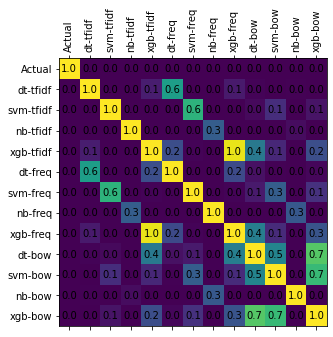

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.716895  0.665698    0.691296  0.671311
xgb-bow    0.706621  0.662791    0.684706  0.648361
dt-bow     0.718037  0.610465    0.664251  0.540984
svm-freq   0.802511  0.520349    0.661430  0.731967
xgb-tfidf  0.686073  0.633721    0.659897  0.561475
svm-tfidf  0.825342  0.494186    0.659764  0.636885
xgb-freq   0.698630  0.604651    0.651641  0.722951
dt-freq    0.676941  0.575581    0.626261  0.672131
dt-tfidf   0.663242  0.569767    0.616505  0.687705
nb-bow     0.546804  0.674419    0.610611  0.702459
nb-freq    0.518265  0.671512    0.594888  0.582787
nb-tfidf   0.482877  0.688953    0.585915  0.694262

Mean: 0.6697819410068534




Method: SMOTETomek

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


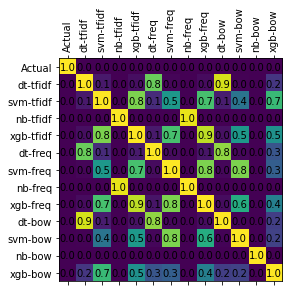

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.801370  0.531977    0.666673  0.713115
svm-freq   0.801370  0.514535    0.657952  0.421311
xgb-bow    0.761416  0.543605    0.652510  0.715574
xgb-freq   0.804795  0.488372    0.646583  0.708197
svm-tfidf  0.793379  0.491279    0.642329  0.677869
xgb-tfidf  0.809361  0.468023    0.638692  0.672131
dt-bow     0.721461  0.552326    0.636893  0.673770
dt-freq    0.788813  0.395349    0.592081  0.720492
dt-tfidf   0.785388  0.383721    0.584555  0.422131
nb-bow     0.468037  0.636628    0.552332  0.725410
nb-tfidf   0.272831  0.799419    0.536125  0.700000
nb-freq    0.279680  0.784884    0.532282  0.515574

Mean: 0.6414621470172601




Method: RandomOver

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


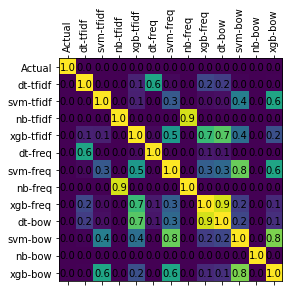

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.759132  0.616279    0.687706  0.444262
xgb-bow    0.781963  0.575581    0.678772  0.700820
svm-tfidf  0.821918  0.511628    0.666773  0.668033
svm-freq   0.792237  0.511628    0.651933  0.734426
dt-bow     0.754566  0.540698    0.647632  0.694262
xgb-tfidf  0.784247  0.488372    0.636309  0.445902
xgb-freq   0.780822  0.468023    0.624423  0.657377
dt-tfidf   0.767123  0.415698    0.591410  0.713115
nb-bow     0.482877  0.691860    0.587369  0.718852
dt-freq    0.754566  0.409884    0.582225  0.692623
nb-freq    0.302511  0.805233    0.553872  0.723770
nb-tfidf   0.309361  0.793605    0.551483  0.541803

Mean: 0.6507620220387025




Method: ADASYN

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


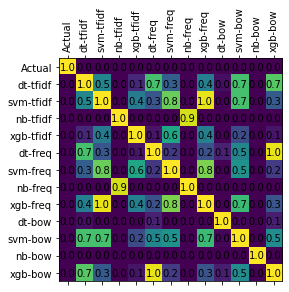

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-freq   0.751142  0.572674    0.661908  0.672951
svm-bow    0.723744  0.595930    0.659837  0.414754
svm-tfidf  0.740868  0.578488    0.659678  0.700820
xgb-bow    0.702055  0.601744    0.651899  0.695902
xgb-tfidf  0.797945  0.491279    0.644612  0.680328
xgb-freq   0.771689  0.502907    0.637298  0.711475
dt-bow     0.670091  0.561047    0.615569  0.639344
dt-tfidf   0.793379  0.392442    0.592910  0.695082
dt-freq    0.786530  0.383721    0.585125  0.413115
nb-bow     0.446347  0.630814    0.538580  0.687705
nb-freq    0.267123  0.790698    0.528910  0.498361
nb-tfidf   0.265982  0.787791    0.526886  0.673770

Mean: 0.6387088408034569




Method: none

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


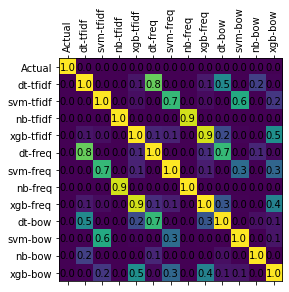

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.918950  0.415698    0.667324  0.474590
xgb-bow    0.867580  0.415698    0.641639  0.727049
nb-bow     0.704338  0.563953    0.634146  0.777049
svm-tfidf  0.940639  0.325581    0.633110  0.767213
xgb-tfidf  0.864155  0.377907    0.621031  0.695902
dt-bow     0.813927  0.424419    0.619173  0.704098
xgb-freq   0.863014  0.375000    0.619007  0.759016
svm-freq   0.949772  0.273256    0.611514  0.690164
dt-freq    0.825342  0.366279    0.595811  0.472951
dt-tfidf   0.820776  0.357558    0.589167  0.725410
nb-tfidf   0.361872  0.761628    0.561750  0.664754
nb-freq    0.359589  0.761628    0.560608  0.740164

Mean: 0.6426368841947052




Method: aug

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


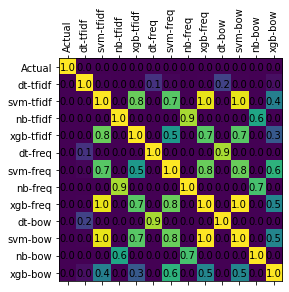

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
xgb-bow    0.740868  0.619186    0.680027  0.715574
svm-bow    0.787671  0.552326    0.669998  0.637705
xgb-tfidf  0.807078  0.526163    0.666620  0.456557
xgb-freq   0.803653  0.511628    0.657640  0.727869
svm-tfidf  0.808219  0.502907    0.655563  0.722131
svm-freq   0.816210  0.459302    0.637756  0.666393
dt-tfidf   0.734018  0.494186    0.614102  0.459836
dt-bow     0.676941  0.549419    0.613180  0.640984
dt-freq    0.697489  0.485465    0.591477  0.721311
nb-freq    0.307078  0.848837    0.577957  0.467213
nb-tfidf   0.304795  0.843023    0.573909  0.706557
nb-bow     0.340183  0.790698    0.565440  0.721311

Mean: 0.6541284787740665




Overall scores:
Friedman Chi Square Statistic: 22.952380952380963. p-value: 0.0003447155929832699.
           RandomUnder  SMOTETomek  RandomOver    ADASYN      none       aug
Actual        1.000000    1.000000    1.000000  1.000000  1.000000

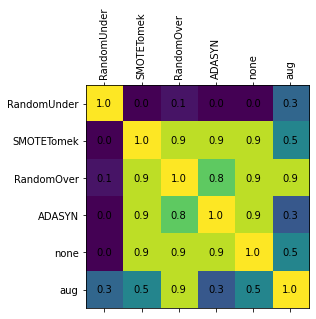

In [12]:
task_eval('binary')


Task: Strat-Binary


Method: RandomUnder

Task: strat-binary.
Cochran's Q test p-value: 4.258946078581124e-90
Post-hoc Dunn test array:


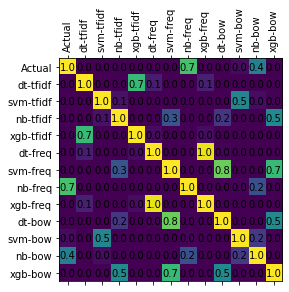

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
xgb-tfidf  0.590183  0.270349    0.430266  0.491803
dt-tfidf   0.583333  0.258721    0.421027  0.339344
dt-freq    0.551370  0.218023    0.384697  0.500000
dt-bow     0.437215  0.325581    0.381398  0.400000
xgb-freq   0.566210  0.183140    0.374675  0.377869
xgb-bow    0.426941  0.302326    0.364633  0.274590
nb-tfidf   0.402968  0.313953    0.358461  0.458197
svm-tfidf  0.339041  0.340116    0.339579  0.405738
svm-bow    0.332192  0.305233    0.318712  0.324590
nb-bow     0.272831  0.360465    0.316648  0.391803
svm-freq   0.522831  0.087209    0.305020  0.457377
nb-freq    0.311644  0.180233    0.245938  0.297541

Mean: 0.4031579549260339




Method: SMOTETomek

Task: strat-binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


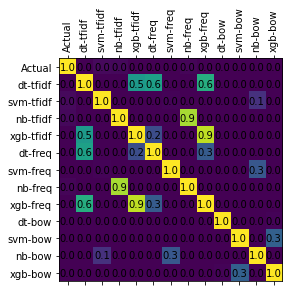

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
xgb-tfidf  0.828767  0.031977    0.430372  0.591803
xgb-freq   0.826484  0.029070    0.427777  0.327049
dt-tfidf   0.812785  0.029070    0.420928  0.236066
dt-freq    0.800228  0.020349    0.410289  0.604098
svm-bow    0.700913  0.029070    0.364992  0.580328
xgb-bow    0.667808  0.040698    0.354253  0.378689
dt-bow     0.595890  0.037791    0.316841  0.232787
svm-freq   0.495434  0.081395    0.288415  0.601639
nb-bow     0.449772  0.119186    0.284479  0.438525
svm-tfidf  0.404110  0.130814    0.267462  0.511475
nb-freq    0.199772  0.316860    0.258316  0.490984
nb-tfidf   0.207763  0.308140    0.257951  0.356557

Mean: 0.39092863969417013




Method: RandomOver

Task: strat-binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


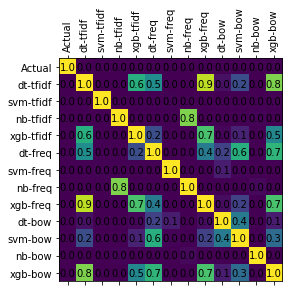

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
xgb-bow    0.765982  0.122093    0.444037  0.575410
xgb-tfidf  0.819635  0.037791    0.428713  0.589344
svm-bow    0.743151  0.113372    0.428261  0.513934
dt-tfidf   0.803653  0.043605    0.423629  0.213934
xgb-freq   0.810502  0.034884    0.422693  0.457377
dt-bow     0.716895  0.122093    0.419494  0.209016
dt-freq    0.785388  0.040698    0.413043  0.599180
svm-freq   0.670091  0.116279    0.393185  0.591803
svm-tfidf  0.582192  0.139535    0.360863  0.549180
nb-tfidf   0.172374  0.319767    0.246071  0.565574
nb-freq    0.165525  0.319767    0.242646  0.162295
nb-bow     0.110731  0.293605    0.202168  0.584426

Mean: 0.4172925805213158




Method: ADASYN

Task: strat-binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


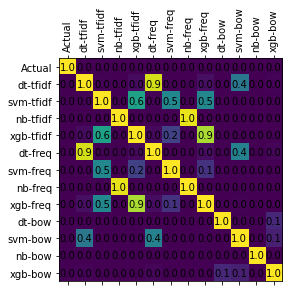

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-freq   0.949772  0.154070    0.551921  0.209016
svm-tfidf  0.926941  0.159884    0.543412  0.699180
xgb-tfidf  0.964612  0.023256    0.493934  0.654918
xgb-freq   0.961187  0.020349    0.490768  0.710656
svm-bow    0.845890  0.107558    0.476724  0.208197
dt-freq    0.899543  0.026163    0.462853  0.725410
dt-tfidf   0.904110  0.020349    0.462229  0.653279
xgb-bow    0.793379  0.119186    0.456283  0.695902
dt-bow     0.746575  0.125000    0.435788  0.571311
nb-freq    0.165525  0.316860    0.241193  0.114754
nb-tfidf   0.168950  0.311047    0.239998  0.637705
nb-bow     0.113014  0.119186    0.116100  0.603279

Mean: 0.4593232574476601




Method: none

Task: strat-binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


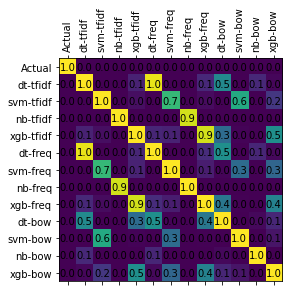

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.918950  0.415698    0.667324  0.474590
xgb-bow    0.867580  0.415698    0.641639  0.727049
nb-bow     0.704338  0.563953    0.634146  0.777049
svm-tfidf  0.940639  0.325581    0.633110  0.767213
dt-bow     0.818493  0.430233    0.624363  0.709016
xgb-tfidf  0.864155  0.377907    0.621031  0.695902
xgb-freq   0.863014  0.375000    0.619007  0.759016
svm-freq   0.949772  0.273256    0.611514  0.695082
dt-freq    0.824201  0.369186    0.596693  0.472951
dt-tfidf   0.823059  0.369186    0.596123  0.725410
nb-tfidf   0.361872  0.761628    0.561750  0.664754
nb-freq    0.359589  0.761628    0.560608  0.740164

Mean: 0.6436390611087967




Method: aug

Task: strat-binary.
Cochran's Q test p-value: 2.0952650101323494e-92
Post-hoc Dunn test array:


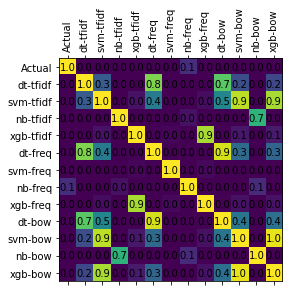

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-freq   0.746575  0.011628    0.379102  0.429508
xgb-freq   0.651826  0.090116    0.370971  0.352459
xgb-tfidf  0.658676  0.061047    0.359861  0.450820
dt-freq    0.531963  0.186047    0.359005  0.436066
dt-bow     0.537671  0.177326    0.357498  0.493443
xgb-bow    0.585616  0.119186    0.352401  0.539344
svm-tfidf  0.595890  0.081395    0.338643  0.434426
dt-tfidf   0.554795  0.110465    0.332630  0.312295
svm-bow    0.613014  0.046512    0.329763  0.490164
nb-tfidf   0.410959  0.203488    0.307224  0.453279
nb-bow     0.405251  0.186047    0.295649  0.343443
nb-freq    0.351598  0.212209    0.281904  0.454098

Mean: 0.389588489719901




Overall scores:
Friedman Chi Square Statistic: 31.904761904761944. p-value: 6.2049032186964e-06.
           RandomUnder  SMOTETomek  RandomOver    ADASYN      none       aug
Actual        1.000000    1.000000    1.000000  1.000000  1.000000  1

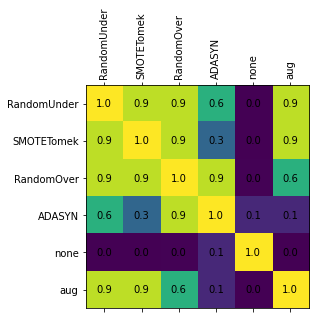

In [13]:
task_eval('strat-binary')


Task: 5Type


Method: RandomUnder

Task: 5type.
Cochran's Q test p-value: 1.467281451377e-311
Post-hoc Dunn test array:


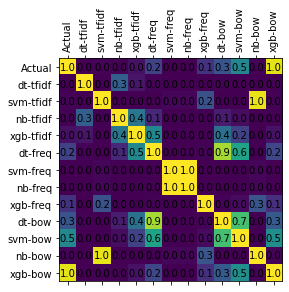

            Score 0   Score 1  Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000    1.000  1.000000  1.000000    1.000000   
dt-freq    0.359589  0.341176    0.250  0.261905  0.354839    0.313502   
xgb-bow    0.328767  0.394118    0.125  0.357143  0.241935    0.289393   
nb-freq    0.163242  0.452941    0.000  0.476190  0.346774    0.287830   
dt-bow     0.377854  0.376471    0.125  0.380952  0.112903    0.274636   
svm-bow    0.348174  0.435294    0.000  0.380952  0.177419    0.268368   
nb-tfidf   0.418950  0.400000    0.125  0.214286  0.177419    0.267131   
nb-bow     0.288813  0.282353    0.125  0.357143  0.185484    0.247758   
xgb-tfidf  0.417808  0.311765    0.125  0.238095  0.137097    0.245953   
xgb-freq   0.304795  0.282353    0.000  0.285714  0.314516    0.237476   
dt-tfidf   0.477169  0.276471    0.125  0.071429  0.177419    0.225497   
svm-tfidf  0.310502  0.205882    0.125  0.238095  0.169355    0.209767   
svm-freq   0.205479  0.270588    0.000

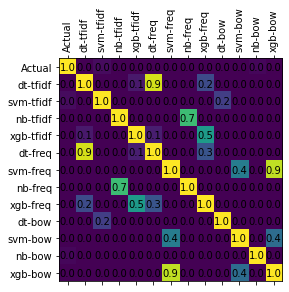

            Score 0   Score 1  Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000    1.000  1.000000  1.000000    1.000000   
svm-freq   0.545662  0.464706    0.000  0.309524  0.177419    0.299462   
xgb-freq   0.731735  0.329412    0.000  0.214286  0.209677    0.297022   
xgb-tfidf  0.755708  0.323529    0.000  0.214286  0.169355    0.292576   
svm-tfidf  0.413242  0.405882    0.000  0.404762  0.201613    0.285100   
dt-tfidf   0.719178  0.276471    0.000  0.261905  0.112903    0.274091   
xgb-bow    0.552511  0.417647    0.000  0.166667  0.217742    0.270913   
dt-bow     0.448630  0.441176    0.000  0.214286  0.233871    0.267593   
svm-bow    0.585616  0.405882    0.000  0.142857  0.193548    0.265581   
nb-tfidf   0.144977  0.323529    0.250  0.380952  0.201613    0.260214   
nb-bow     0.303653  0.329412    0.125  0.309524  0.193548    0.252227   
nb-freq    0.142694  0.288235    0.250  0.380952  0.185484    0.249473   
dt-freq    0.726027  0.270588    0.000

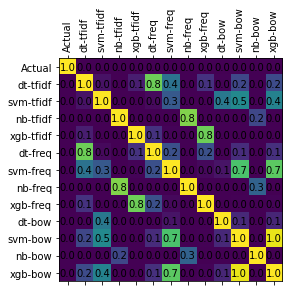

            Score 0   Score 1  Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000    1.000  1.000000  1.000000    1.000000   
xgb-bow    0.628995  0.382353    0.375  0.357143  0.161290    0.380956   
svm-tfidf  0.595890  0.376471    0.000  0.500000  0.225806    0.339633   
svm-freq   0.621005  0.488235    0.000  0.452381  0.129032    0.338131   
svm-bow    0.644977  0.347059    0.250  0.238095  0.137097    0.323446   
dt-bow     0.599315  0.317647    0.250  0.238095  0.185484    0.318108   
nb-bow     0.078767  0.294118    0.375  0.547619  0.233871    0.305875   
xgb-tfidf  0.721461  0.364706    0.000  0.095238  0.233871    0.283055   
xgb-freq   0.712329  0.400000    0.000  0.095238  0.193548    0.280223   
dt-freq    0.695205  0.323529    0.000  0.119048  0.177419    0.263040   
dt-tfidf   0.689498  0.294118    0.000  0.119048  0.201613    0.260855   
nb-freq    0.119863  0.300000    0.250  0.452381  0.177419    0.259933   
nb-tfidf   0.122146  0.329412    0.250

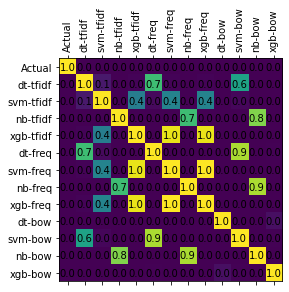

            Score 0   Score 1  Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000    1.000  1.000000  1.000000    1.000000   
nb-bow     0.089041  0.311765    0.125  0.785714  0.266129    0.315530   
svm-tfidf  0.899543  0.158824    0.250  0.000000  0.048387    0.271351   
svm-freq   0.923516  0.182353    0.250  0.000000  0.000000    0.271174   
nb-tfidf   0.117580  0.347059    0.250  0.404762  0.185484    0.260977   
nb-freq    0.115297  0.294118    0.250  0.428571  0.185484    0.254694   
xgb-freq   0.897260  0.270588    0.000  0.000000  0.080645    0.249699   
xgb-tfidf  0.898402  0.276471    0.000  0.000000  0.072581    0.249491   
dt-tfidf   0.819635  0.264706    0.000  0.023810  0.104839    0.242598   
dt-freq    0.818493  0.217647    0.000  0.023810  0.096774    0.231345   
svm-bow    0.803653  0.335294    0.000  0.000000  0.016129    0.231015   
xgb-bow    0.731735  0.276471    0.000  0.071429  0.040323    0.223991   
dt-bow     0.672374  0.252941    0.000

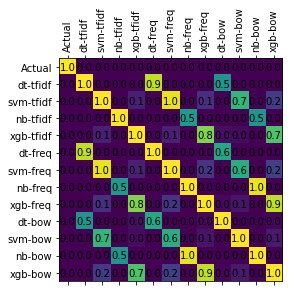

            Score 0   Score 1  Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000    1.000  1.000000  1.000000    1.000000   
nb-bow     0.090183  0.305882    0.375  0.547619  0.241935    0.312124   
dt-bow     0.818493  0.370588    0.000  0.142857  0.072581    0.280904   
svm-bow    0.942922  0.435294    0.000  0.000000  0.008065    0.277256   
xgb-bow    0.897260  0.370588    0.000  0.047619  0.040323    0.271158   
svm-tfidf  0.948630  0.317647    0.000  0.000000  0.040323    0.261320   
xgb-freq   0.904110  0.288235    0.000  0.000000  0.096774    0.257824   
nb-tfidf   0.118721  0.352941    0.250  0.404762  0.161290    0.257543   
xgb-tfidf  0.899543  0.282353    0.000  0.000000  0.088710    0.254121   
nb-freq    0.115297  0.270588    0.250  0.428571  0.169355    0.246762   
svm-freq   0.962329  0.270588    0.000  0.000000  0.000000    0.246583   
dt-freq    0.823059  0.276471    0.000  0.023810  0.104839    0.245636   
dt-tfidf   0.824201  0.247059    0.000

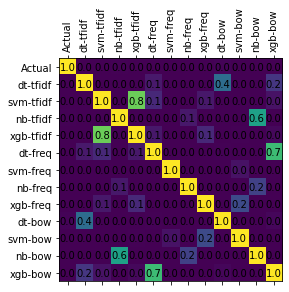

            Score 0   Score 1  Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000    1.000  1.000000  1.000000    1.000000   
dt-bow     0.414384  0.335294    0.500  0.452381  0.298387    0.400089   
dt-tfidf   0.437215  0.364706    0.375  0.500000  0.274194    0.390223   
xgb-tfidf  0.528539  0.411765    0.250  0.428571  0.330645    0.389904   
svm-bow    0.591324  0.452941    0.125  0.285714  0.443548    0.379706   
dt-freq    0.497717  0.382353    0.375  0.380952  0.225806    0.372366   
xgb-bow    0.477169  0.335294    0.125  0.404762  0.362903    0.341026   
xgb-freq   0.597032  0.376471    0.125  0.333333  0.250000    0.336367   
svm-tfidf  0.568493  0.247059    0.250  0.380952  0.233871    0.336075   
nb-bow     0.252283  0.317647    0.250  0.500000  0.314516    0.326889   
svm-freq   0.686073  0.423529    0.000  0.261905  0.225806    0.319463   
nb-tfidf   0.279680  0.341176    0.125  0.428571  0.233871    0.281660   
nb-freq    0.227169  0.335294    0.125

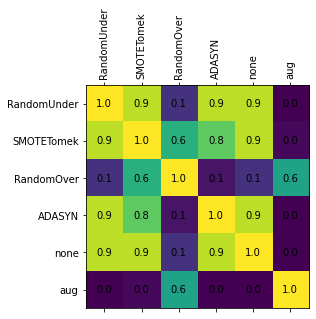

In [14]:
task_eval('5type')


Task: 4Type


Method: RandomUnder

Task: 4type.
Cochran's Q test p-value: 5.684879652185987e-309
Post-hoc Dunn test array:


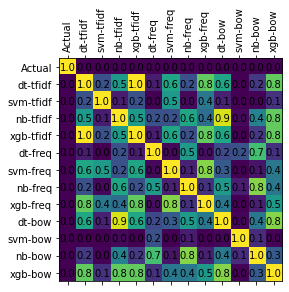

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
nb-bow     0.435294    0.625  0.615385  0.186992    0.465668  0.385294
dt-freq    0.482353    0.500  0.358974  0.252033    0.398340  0.273529
svm-bow    0.576471    0.250  0.512821  0.211382    0.387668  0.317647
svm-tfidf  0.335294    0.500  0.461538  0.113821    0.352663  0.329412
dt-bow     0.470588    0.375  0.435897  0.121951    0.350859  0.317647
xgb-bow    0.435294    0.375  0.435897  0.146341    0.348133  0.297059
dt-tfidf   0.400000    0.375  0.461538  0.154472    0.347753  0.361765
nb-tfidf   0.388235    0.125  0.615385  0.203252    0.332968  0.305882
xgb-tfidf  0.382353    0.250  0.461538  0.186992    0.320221  0.338235
xgb-freq   0.376471    0.375  0.307692  0.203252    0.315604  0.429412
nb-freq    0.482353    0.250  0.307692  0.219512    0.314889  0.341176
svm-freq   0.352941    0.250  0.358974  0.203252    0.291292  0.370588

Mean:

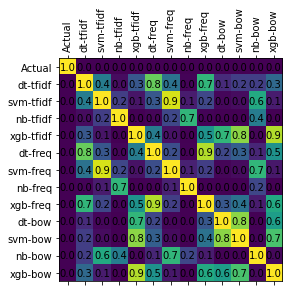

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
nb-bow     0.511765    0.500  0.589744  0.138211    0.434930  0.491176
dt-bow     0.594118    0.125  0.641026  0.349593    0.427434  0.405882
svm-bow    0.600000    0.250  0.487179  0.357724    0.423726  0.438235
xgb-bow    0.552941    0.125  0.538462  0.373984    0.397597  0.402941
xgb-tfidf  0.547059    0.000  0.538462  0.406504    0.373006  0.335294
svm-tfidf  0.482353    0.000  0.794872  0.203252    0.370119  0.476471
svm-freq   0.500000    0.000  0.692308  0.203252    0.348890  0.385294
dt-freq    0.564706    0.000  0.512821  0.300813    0.344585  0.450000
nb-tfidf   0.523529    0.375  0.307692  0.130081    0.334076  0.455882
dt-tfidf   0.564706    0.000  0.461538  0.284553    0.327699  0.482353
xgb-freq   0.576471    0.000  0.384615  0.341463    0.325637  0.352941
nb-freq    0.523529    0.375  0.256410  0.097561    0.313125  0.500000

Mean:

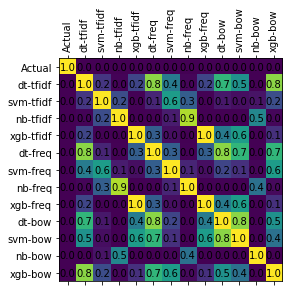

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
dt-bow     0.588235    0.375  0.564103  0.235772    0.440778  0.379412
xgb-bow    0.517647    0.250  0.564103  0.268293    0.400011  0.485294
svm-bow    0.594118    0.125  0.615385  0.252033    0.396634  0.435294
svm-tfidf  0.441176    0.125  0.820513  0.170732    0.389355  0.302941
xgb-freq   0.564706    0.000  0.461538  0.414634    0.360220  0.485294
xgb-tfidf  0.576471    0.000  0.461538  0.398374    0.359096  0.332353
svm-freq   0.505882    0.000  0.717949  0.186992    0.352706  0.461765
nb-bow     0.441176    0.500  0.282051  0.105691    0.332230  0.426471
dt-freq    0.517647    0.000  0.435897  0.373984    0.331882  0.402941
nb-freq    0.517647    0.375  0.307692  0.097561    0.324475  0.338235
nb-tfidf   0.505882    0.375  0.282051  0.105691    0.317156  0.452941
dt-tfidf   0.547059    0.000  0.282051  0.357724    0.296708  0.444118

Mean:

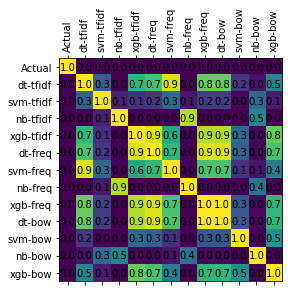

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
nb-bow     0.476471    0.500  0.794872  0.113821    0.471291  0.491176
xgb-bow    0.658824    0.125  0.256410  0.357724    0.349489  0.476471
dt-bow     0.670588    0.125  0.256410  0.292683    0.336170  0.479412
nb-tfidf   0.529412    0.375  0.307692  0.121951    0.333514  0.382353
nb-freq    0.535294    0.375  0.307692  0.097561    0.328887  0.517647
svm-bow    0.735294    0.125  0.025641  0.398374    0.321077  0.461765
dt-freq    0.670588    0.000  0.282051  0.300813    0.313363  0.352941
xgb-tfidf  0.652941    0.000  0.230769  0.349593    0.308326  0.347059
xgb-freq   0.647059    0.000  0.230769  0.341463    0.304823  0.473529
dt-tfidf   0.652941    0.000  0.205128  0.308943    0.291753  0.458824
svm-freq   0.676471    0.000  0.000000  0.333333    0.252451  0.420588
svm-tfidf  0.558824    0.000  0.000000  0.390244    0.237267  0.473529

Mean:

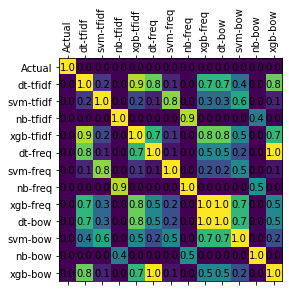

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
dt-bow     0.723529    0.000  0.333333  0.325203    0.345516  0.505882
nb-bow     0.458824    0.500  0.307692  0.105691    0.343052  0.488235
xgb-freq   0.700000    0.000  0.256410  0.382114    0.334631  0.488235
nb-tfidf   0.517647    0.375  0.307692  0.121951    0.330573  0.314706
xgb-tfidf  0.694118    0.000  0.256410  0.357724    0.327063  0.341176
nb-freq    0.523529    0.375  0.307692  0.097561    0.325946  0.535294
dt-tfidf   0.694118    0.000  0.256410  0.341463    0.322998  0.564706
xgb-bow    0.658824    0.000  0.282051  0.349593    0.322617  0.517647
dt-freq    0.682353    0.000  0.256410  0.325203    0.315992  0.517647
svm-freq   0.829412    0.000  0.000000  0.414634    0.311011  0.500000
svm-tfidf  0.800000    0.000  0.000000  0.430894    0.307724  0.555882
svm-bow    0.758824    0.000  0.025641  0.422764    0.301807  0.347059

Mean:

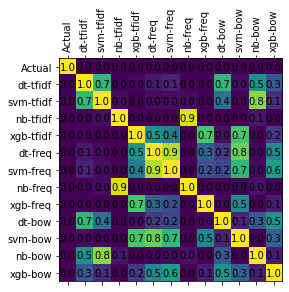

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
dt-freq    0.647059    0.500  0.487179  0.390244    0.506121  0.558824
xgb-freq   0.658824    0.375  0.487179  0.495935    0.504234  0.355882
xgb-tfidf  0.670588    0.375  0.487179  0.439024    0.492948  0.441176
dt-tfidf   0.494118    0.500  0.589744  0.365854    0.487429  0.573529
dt-bow     0.529412    0.500  0.487179  0.398374    0.478741  0.352941
xgb-bow    0.535294    0.250  0.512821  0.471545    0.442415  0.526471
svm-bow    0.647059    0.250  0.333333  0.487805    0.429549  0.532353
svm-freq   0.676471    0.000  0.564103  0.341463    0.395509  0.458824
nb-bow     0.411765    0.125  0.538462  0.447154    0.380595  0.544118
svm-tfidf  0.476471    0.000  0.589744  0.373984    0.360049  0.476471
nb-freq    0.376471    0.000  0.461538  0.308943    0.286738  0.502941
nb-tfidf   0.394118    0.000  0.358974  0.325203    0.269574  0.432353

Mean:

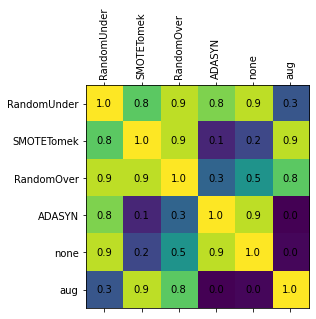

In [15]:
task_eval('4type')

In [16]:
def compare_aug(method):
    for task in ['binary', 'strat-binary', '5type', '4type']:
        df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-{method}.csv')
        aug_df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-aug.csv')
        df['Common'] = df.apply(lambda x: mode(np.array(x, dtype=np.int64)), axis=1)
        aug_df['Common'] = aug_df.apply(lambda x: mode(np.array(x, dtype=np.int64)), axis=1)
        result = cochrans_q([df['Common'], aug_df['Common']])
        
        #get row with int correct/incorrect
        aug_columns = list(aug_df.columns.values)
        common, actual = aug_columns.index('Common'), aug_columns.index('Actual')
        aug_df["Correct"] = aug_df.apply(lambda x: int(x[common] == x[actual]), axis=1)
        columns = list(df.columns.values)
        common, actual = columns.index('Common'), columns.index('Actual')
        df["Correct"] = df.apply(lambda x: int(x[common] == x[actual]), axis=1)
        
        print(f'Task: {task}')
        print(f"McNemar's test p-value: {result.pvalue}\n")
        print(f'Augmented mean accuracy: {aug_df["Correct"].mean()}.\nOriginal mean accuracy: {df["Correct"].mean()}.')
        print('\n')

In [17]:
compare_aug('RandomUnder')

Task: binary
McNemar's test p-value: 9.328091476448832e-28

Augmented mean accuracy: 0.740983606557377.
Original mean accuracy: 0.7311475409836066.


Task: strat-binary
McNemar's test p-value: 8.383662354331988e-07

Augmented mean accuracy: 0.559016393442623.
Original mean accuracy: 0.5745901639344262.


Task: 5type
McNemar's test p-value: 6.481394313598987e-05

Augmented mean accuracy: 0.6377049180327868.
Original mean accuracy: 0.49098360655737705.


Task: 4type
McNemar's test p-value: 0.011978743128064174

Augmented mean accuracy: 0.6176470588235294.
Original mean accuracy: 0.45.


